In [1]:
import geopandas as gpd
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import json
import ipywidgets as widgets

In [2]:
# Read the data
neighbourhoods = gpd.read_file("./dsan_5200_project/neighbourhoods.geojson")
neighbourhoods['neighbourhood_cleansed'] = neighbourhoods['neighbourhood']

In [3]:
geojson_dict = json.loads(neighbourhoods.to_json())
geojson_dict['features'][0]['properties']

{'neighbourhood': 'Congress Heights, Bellevue, Washington Highlands',
 'neighbourhood_group': None,
 'neighbourhood_cleansed': 'Congress Heights, Bellevue, Washington Highlands'}

In [4]:
df = pd.read_csv("./dsan_5200_project/cleaned_data.csv")
pd.set_option('display.max_columns', None)

Q1 = df['price_num'].quantile(0.25)
Q3 = df['price_num'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price_num'] <= upper_bound) & (df['price_num'] >= lower_bound)]
df.reset_index(drop=True, inplace=True)

In [5]:
top_5_list = df['neighbourhood_cleansed'].value_counts().head(10).keys()
df_top_5 = df[df['neighbourhood_cleansed'].isin(top_5_list)]

In [6]:
neighbourhoods['neighbourhood_cleansed'] = neighbourhoods['neighbourhood']
df['median_price'] = df.groupby('neighbourhood_cleansed')['price_num'].transform('median')
df['median_location_review'] = df.groupby('neighbourhood_cleansed')['review_scores_location'].transform('median')
merged_gdf = neighbourhoods.merge(df, on='neighbourhood_cleansed', how='right')

## What Factors Influenced Airbnb Price

The dataset from Airbnb features several columns, including longitude, latitude, superhost status, neighborhood, number of bathrooms, reviews on cleanliness, location, among others. When predicting or finding correlations with price, it appears that the number of bathrooms and accommodation capacity are the most influential factors. Visual analysis through plotting these variables against price confirms their significant impact. Interestingly, reviews on aspects like cleanliness did not show a substantial correlation with price, likely because most ratings were high across the board. Additionally, categorical variables such as superhost status did not provide significant additional insights into pricing trends.


In [7]:
df['bathroom_num'] = df['bathrooms_text'].str.extract(r'(\d+)', expand=False)
df['bathroom_num'] = pd.to_numeric(df['bathroom_num'])

fig=px.box(df, x='bathroom_num',y='price_num')
fig.update_xaxes(title_text='Number of Bathroom')
fig.update_yaxes(title_text='Price')
fig.update_layout(title='Price of Airbnbs by the Number of Bathrooms')
fig.show()

In [8]:
fig = px.box(df, x='accommodates',y='price_num')
fig.update_xaxes(title_text='Number of Accommodates Possible')
fig.update_yaxes(title_text='Price')
fig.update_layout(title='Price of Airbnbs by the Number of Accommodates')
fig.show()

## Price by Neighborhood

The dataset suggests that geographical location, particularly the neighborhood, might also influence Airbnb pricing. Observations from the map indicate that higher-priced Airbnb listings are predominantly clustered around central areas, hinting at a potential correlation between location and price. Consequently, we decided to further explore this by examining the distance from each Airbnb to significant landmarks in Washington DC. Our aim is to determine if proximity to these landmarks correlates with the pricing of the listings.


In [9]:
# fig = px.choropleth_mapbox(
#     merged_gdf,
#     geojson=geojson_dict,
#     locations='neighbourhood_cleansed',  
#     featureidkey='properties.neighbourhood_cleansed',  
#     color='median_price',  
#     color_continuous_scale="tealrose",  
#     mapbox_style="carto-positron",  
#     zoom=10,  
#     center={"lat": 38.9, "lon": -77.03}, 
#     opacity=0.5,  
#     labels={'neighbourhood_cleansed':'Area','median_price': 'Median Price',}, 
#     hover_data={
#         'neighbourhood_cleansed': True,
#         'price_num': ':.2f',  
#     }
# )
# fig.update_traces(
#     hovertemplate=(
#         "<b>%{customdata[0]}</b><br>"
#         "<span style='font-size:0.9em;'>Median Price:</span> "
#         "<span style='font-size:0.9em;'><b>$%{customdata[1]:.2f}</b></span><br>"
#     )
# )

# fig.update_layout(
#     hoverlabel=dict(
#         font=dict(family="Courier New, monospace", size=12),
#         bordercolor='pink',
#         bgcolor='white'
#     ),
#     title='Median Airbnb Price and Review by Neighborhood in DC',
#     margin={"r": 0, "t": 0, "l": 0, "b": 0},
#     clickmode='event+select'
# )

# fig.show()

## Airbnb Prices and Distance from the National Monument

Washington D.C. is known for its tourist attractions, many of which are concentrated around the National Monument. To explore this influence, we incorporated a "distance from the monument" feature for each Airbnb listing and analyzed its correlation with pricing. Our analysis revealed a discernible pattern: as the distance from the Washington Monument increases, the average Airbnb prices tend to decrease. This suggests that proximity to this landmark may significantly impact rental pricing. We visualized this relationship using a single plot that aggregates data across all neighborhoods, clearly showing a price threshold for each distance bin from the monument.


In [10]:
import math

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) 
    # Radius of earth in miles
    radius = 3956
    distance = radius * c
    return distance

In [11]:
# Target point (e.g., New York City)
target_latitude = 38.9531162
target_longitude = -77.4565388

# Calculate distance from target point to each point in the DataFrame
df['Distance_miles_IAD'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], target_longitude, target_latitude), axis=1)

# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles_IAD', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles_IAD': True, 'price_num': True, 'neighbourhood_cleansed': True},
                 labels={"neighbourhood_cleansed":"Neighbourhood"})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from IAD (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(legend=dict(itemwidth=30,font=dict(size=5)),
                  title='Price of Airbnbs by How Far the Airbnbs are from IAD')


fig.show()

In [12]:
# Target point (e.g., New York City)
target_latitude = 38.889248
target_longitude = -77.050636

# Calculate distance from target point to each point in the DataFrame
df['Distance_miles_LM'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], target_longitude, target_latitude), axis=1)

# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles_LM', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles_LM': True, 'price_num': True, 'neighbourhood_cleansed': True},
                 labels={"neighbourhood_cleansed":"Neighbourhood"})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from Lincoln Memorial (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(legend=dict(itemwidth=30,font=dict(size=5)),
                  title='Price of Airbnbs by How Far the Airbnbs are from Lincoln Memorial')


fig.show()

In [13]:
# Target point (e.g., New York City)
target_latitude = 38.897095
target_longitude = -77.006332

# Calculate distance from target point to each point in the DataFrame
df['Distance_miles_US'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], target_longitude, target_latitude), axis=1)

# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles_US', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles_US': True, 'price_num': True, 'neighbourhood_cleansed': True},
                 labels={"neighbourhood_cleansed":"Neighbourhood"})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from Union Station (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(legend=dict(itemwidth=30,font=dict(size=5)),
                  title='Price of Airbnbs by How Far the Airbnbs are from Union Station')


fig.show()

In [14]:
# Target point (e.g., New York City)
target_latitude = 38.8895
target_longitude = -77.0353


# Calculate distance from target point to each point in the DataFrame
df['Distance_miles'] = df.apply(lambda row: haversine(row['longitude'], row['latitude'], target_longitude, target_latitude), axis=1)

# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles': True, 'price_num': True, 'neighbourhood_cleansed': True},
                 labels={"neighbourhood_cleansed":"Neighbourhood"})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from the National Monument (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(legend=dict(itemwidth=30,font=dict(size=5)),
                  title='Price of Airbnbs by How Far the Airbnbs are from the National Monument')


fig.show()

In [15]:
# Create an interactive scatter plot with tooltips
fig = px.scatter(df, x='Distance_miles', y='price_num', color='neighbourhood_cleansed', 
                 hover_data={'Distance_miles': True, 'price_num': True, 'neighbourhood_cleansed': True},
                 labels={"neighbourhood_cleansed":"Neighbourhood"})

# Update layout to customize the tooltip display
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_xaxes(title_text='Distance from the National Monument (Miles)')
fig.update_yaxes(title_text='Price')
fig.update_layout(legend=dict(itemwidth=30,font=dict(size=5)),
                  title='Price of Airbnbs by How Far the Airbnbs are from the National Monument')

import plotly.graph_objects as go

# Define the slope and y-intercept of your line
slope = -35  # Example slope
y_intercept = 270  # Example y-intercept

# Define x values for your line
x_values = [min(df['Distance_miles']), max(df['Distance_miles'])]

# Calculate y values for your line using the slope and y-intercept
y_values = [slope * x + y_intercept for x in x_values]

# Create a trace for the line plot
line_trace = go.Scatter(
    x=x_values,
    y=y_values,
    mode='lines',
    name='Regression Line',  # You can customize the name of the line
    line=dict(color='red', width=2)  # You can customize the color and width of the line
)

# Add the line trace to your figure
fig.add_trace(line_trace)

# Update layout
fig.update_layout(title='Price of Airbnbs by How Far the Airbnbs are from the National Monument with Regression Line')

# Show the figure
fig.show()

After realizing that the number of bathrooms and accommodations are the main variables correlating with Airbnb prices, we focused on additional feature engineering to derive deeper insights. Given that Washington DC's Airbnbs primarily serve tourists, we evaluated the impact of proximity to key locations on pricing. We began by assessing the distances from two major airports—Dulles and Ronald Reagan—to each Airbnb, discovering that the trend of prices tend to follow a normal distribution with respect to distance from these airports. This indicates that Airbnbs optimally distanced from the airports demand higher prices.

Expanding our analysis, we examined the influence of proximity to Washington DC landmarks such as the Lincoln Memorial, Union Station, and the National Monument. Our findings showed varied impacts on pricing:
 - Lincoln Memorial: The plot revealed some gaps on the left side, indicating that proximity to the Lincoln Memorial does not consistently correlate with higher prices.
 - Union Station: The data displayed a more consistent pattern, resembling a plateau on the left side of the plot, suggesting a moderate correlation with higher prices for closer properties.
 - National Monument: Here, the trend was more distinct. We could draw a line across the plot dividing it into two zones: one where prices are generally lower and another where prices are higher. This suggests a strong correlation between proximity to the National Monument and increased Airbnb pricing.

With having the National monument as our significant landmark, by overlaying neighborhood data on these plots, it was obvious that Airbnbs within the same neighborhood tend to cluster into similar distance 'bins.' Furthermore, each neighborhood appears to have a maximum expected price influenced by its proximity to the National Monument. We plan to delve deeper into the data to understand why some Airbnbs command higher prices than others within the same neighborhood, looking for additional factors that might affect pricing.

## Relationship Between Price and the Distance from the National Monument to Each Neighbourhood

We previously found out that the distance from the National Monument is important in determining the price of the Airbnbs. Yet, there also were some Airbnbs that were beyond the regression line to distinguish the points whose price dropped as the distance from the National Monument to the Airbnbs increased. As these Airbnbs had higher prices compared to those of other Airbnbs located in the same distance or in the same neighbourhood, we wanted to take a closer look into what other factors other than being far from the National Monument or the center of Washington D.C. were influential in increasing the price of these Airbnbs.


In [16]:
above_avg = df[(df['Distance_miles'] * slope + y_intercept) < (df['price_num'])]

In [17]:
above_group = above_avg.groupby(['neighbourhood_cleansed']).size().sort_values(ascending=False)
df_group = df.groupby(['neighbourhood_cleansed']).size().sort_values(ascending=False)

ratio = pd.DataFrame((above_group/df_group).sort_values(ascending=False)).reset_index()
ratio.rename(columns={0:'ratio'}, inplace=True)

In [18]:
above = pd.DataFrame((above_group).sort_values(ascending=False)).reset_index()
above.rename(columns={0:'ratio'}, inplace=True)

In [19]:
import plotly.graph_objects as go

fig = px.choropleth_mapbox(
    above,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  # Column in merged_gdf for neighborhood names
    featureidkey='properties.neighbourhood_cleansed',  # Key in GeoJSON for neighborhood names
    color='ratio',  # Column in merged_gdf for color scale
    color_continuous_scale="tealrose",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 38.9, "lon": -77.03},
    opacity=0.5,
    labels={'value': 'price'}
)

# Add buttons to update layout
fig.update_layout(updatemenus=[{"active": 0}],
                  title="Choropleth Map for the Number of Airbnbs with a Higher Price Compared to Airbnbs within the Same Distance",  # Initial title
                  margin={"r": 0, "t": 0, "l": 0, "b": 0},
                  coloraxis_colorbar_title="Count")

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

First, the Airbnbs that had a higher price than the other Airbnbs in the same distance were extracted. Then, we wanted to see what neighbourhoods had more Airbnbs with a higher price in regards to its distance from the National Monument. What we found was Airbnb that we in the middle part had a high ratio, and we concluded that this is because there are more Airbnbs in these areas and thus would be a divergent range in the price. This plot didn't show the factors that were influential in determining the high price of certain Airbnbs compared to other Airbnbs in the same distance.


In [20]:
import plotly.graph_objects as go

fig = px.choropleth_mapbox(
    ratio,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  # Column in merged_gdf for neighborhood names
    featureidkey='properties.neighbourhood_cleansed',  # Key in GeoJSON for neighborhood names
    color='ratio',  # Column in merged_gdf for color scale
    color_continuous_scale="tealrose",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 38.9, "lon": -77.03},
    opacity=0.5,
    labels={'value': 'price'}
)

# Add buttons to update layout
fig.update_layout(updatemenus=[{"active": 0}],
                  title="Choropleth Map for Ratio",  # Initial title
                  margin={"r": 0, "t": 0, "l": 0, "b": 0},
                  coloraxis_colorbar_title="Ratio")

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Then, instead of counting the number of Airbnbs that were extracted by each neighbourhood, we decided to calculate the ratio of the Airbnbs that had higher prices to the other ones in each neighbourhood. We divided the number of Airbnbs that we extracted by the total number of Airbnbs. When plotting the chrolopleth, what we discovered was quite interesting. Neighbourhoods 'Hawthorne, Barnaby Woods, Chevy Chase' and 'Colonial Village, Shepherd Part, North Portal Estates' have more Airbnbs with higher prices compared to other neighbourhoods. Thus, we wanted to dive deeper into what makes these neighbourhoods have Airbnbs with a high price.


In [21]:
Haw = above_avg[above_avg['neighbourhood_cleansed'].str.contains('Haw')]
Shepherd = above_avg[above_avg['neighbourhood_cleansed'].str.contains('Shepherd')]
Knox = above_avg[above_avg['neighbourhood_cleansed'].str.contains('Knox')]

In [22]:
haw_shp = pd.concat([Haw, Shepherd], axis=0)
haw_shp.reset_index(drop=True, inplace=True)

In [23]:
above_avg = df[(df['Distance_miles'] * slope + y_intercept) < (df['price_num'])]
below_avg = df[(df['Distance_miles'] * slope + y_intercept) >= (df['price_num'])]

above_avg['host_response_num'] = pd.to_numeric(above_avg['host_response_rate'].str.replace('%',''))
below_avg['host_response_num'] = pd.to_numeric(below_avg['host_response_rate'].str.replace('%',''))

In [24]:
above_avg.groupby(['room_type']).size()

room_type
Entire home/apt    1018
Private room        148
Shared room           1
dtype: int64

In [25]:
below_avg.groupby(['room_type']).size()

room_type
Entire home/apt    3154
Hotel room           10
Private room       1124
Shared room          62
dtype: int64

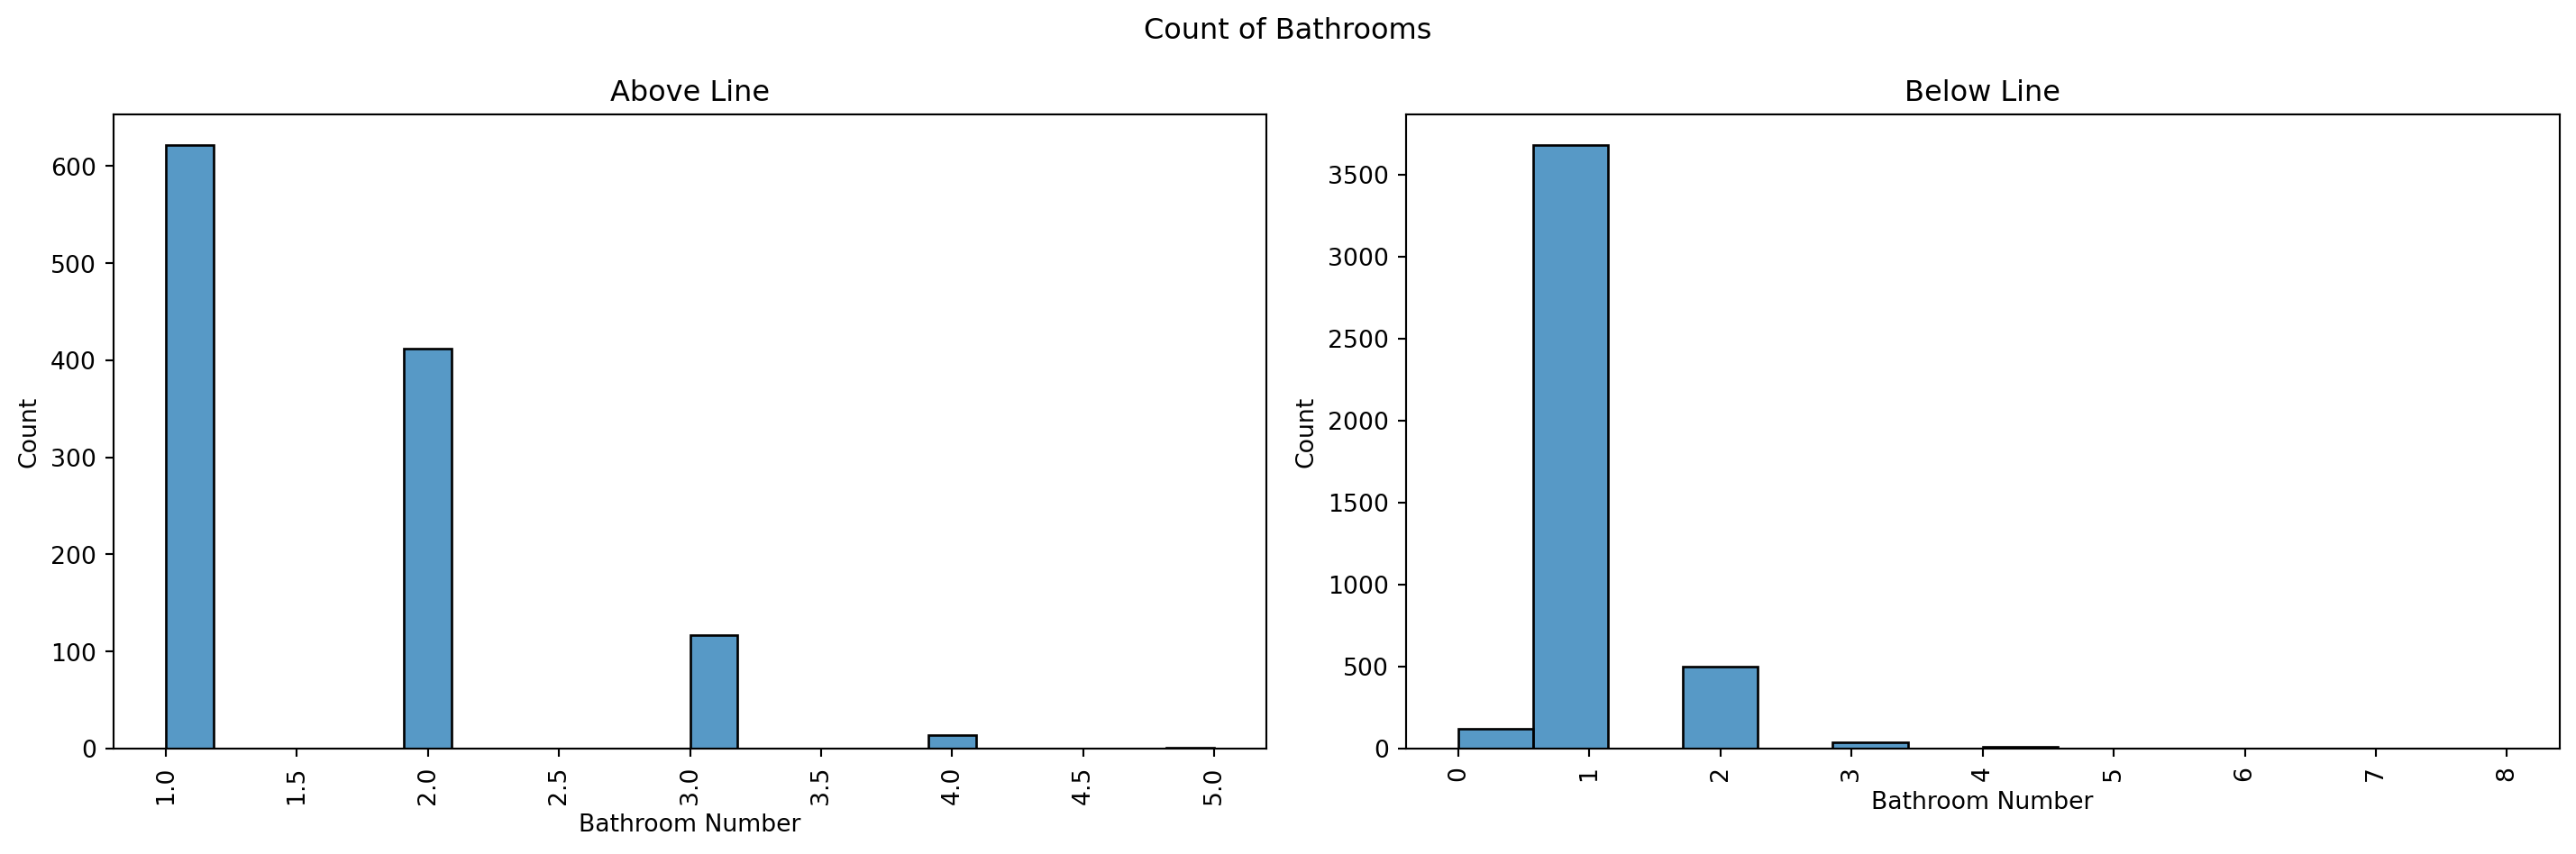

In [26]:
x_a = 'bathroom_num'
data_list = [above_avg,below_avg]
name_list = ['Above Line', 'Below Line']

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each subplot and plot the boxplot
for i, (data, name) in enumerate(zip(data_list, name_list)):
    sns.histplot(data=data, x=x_a, ax=axes[i], palette='Set3')
    axes[i].set_title(name)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('Bathroom Number')
    axes[i].set_ylabel('Count')

plt.suptitle('Count of Bathrooms')
plt.tight_layout()
plt.show()

We were first curious of the number of bathrooms in Airbnbs above the regression line and below the regression line and if there would be any difference between the two places. We found that for Airbnbs below the regression line mainly had one bathrooms whereas Airbnbs above the regression line had several places with 2 or 3 bathrooms relative to places with only one bathroom, which implies that the Airbnbs above the regression line would be larger than those placed below the regression line.


In [27]:
haw_shp.groupby(['property_type']).size()

property_type
Entire condo                          2
Entire guest suite                    6
Entire guesthouse                     2
Entire home                           4
Entire rental unit                   11
Entire townhouse                      2
Private room in bed and breakfast     1
Private room in home                 23
Private room in townhouse             1
dtype: int64

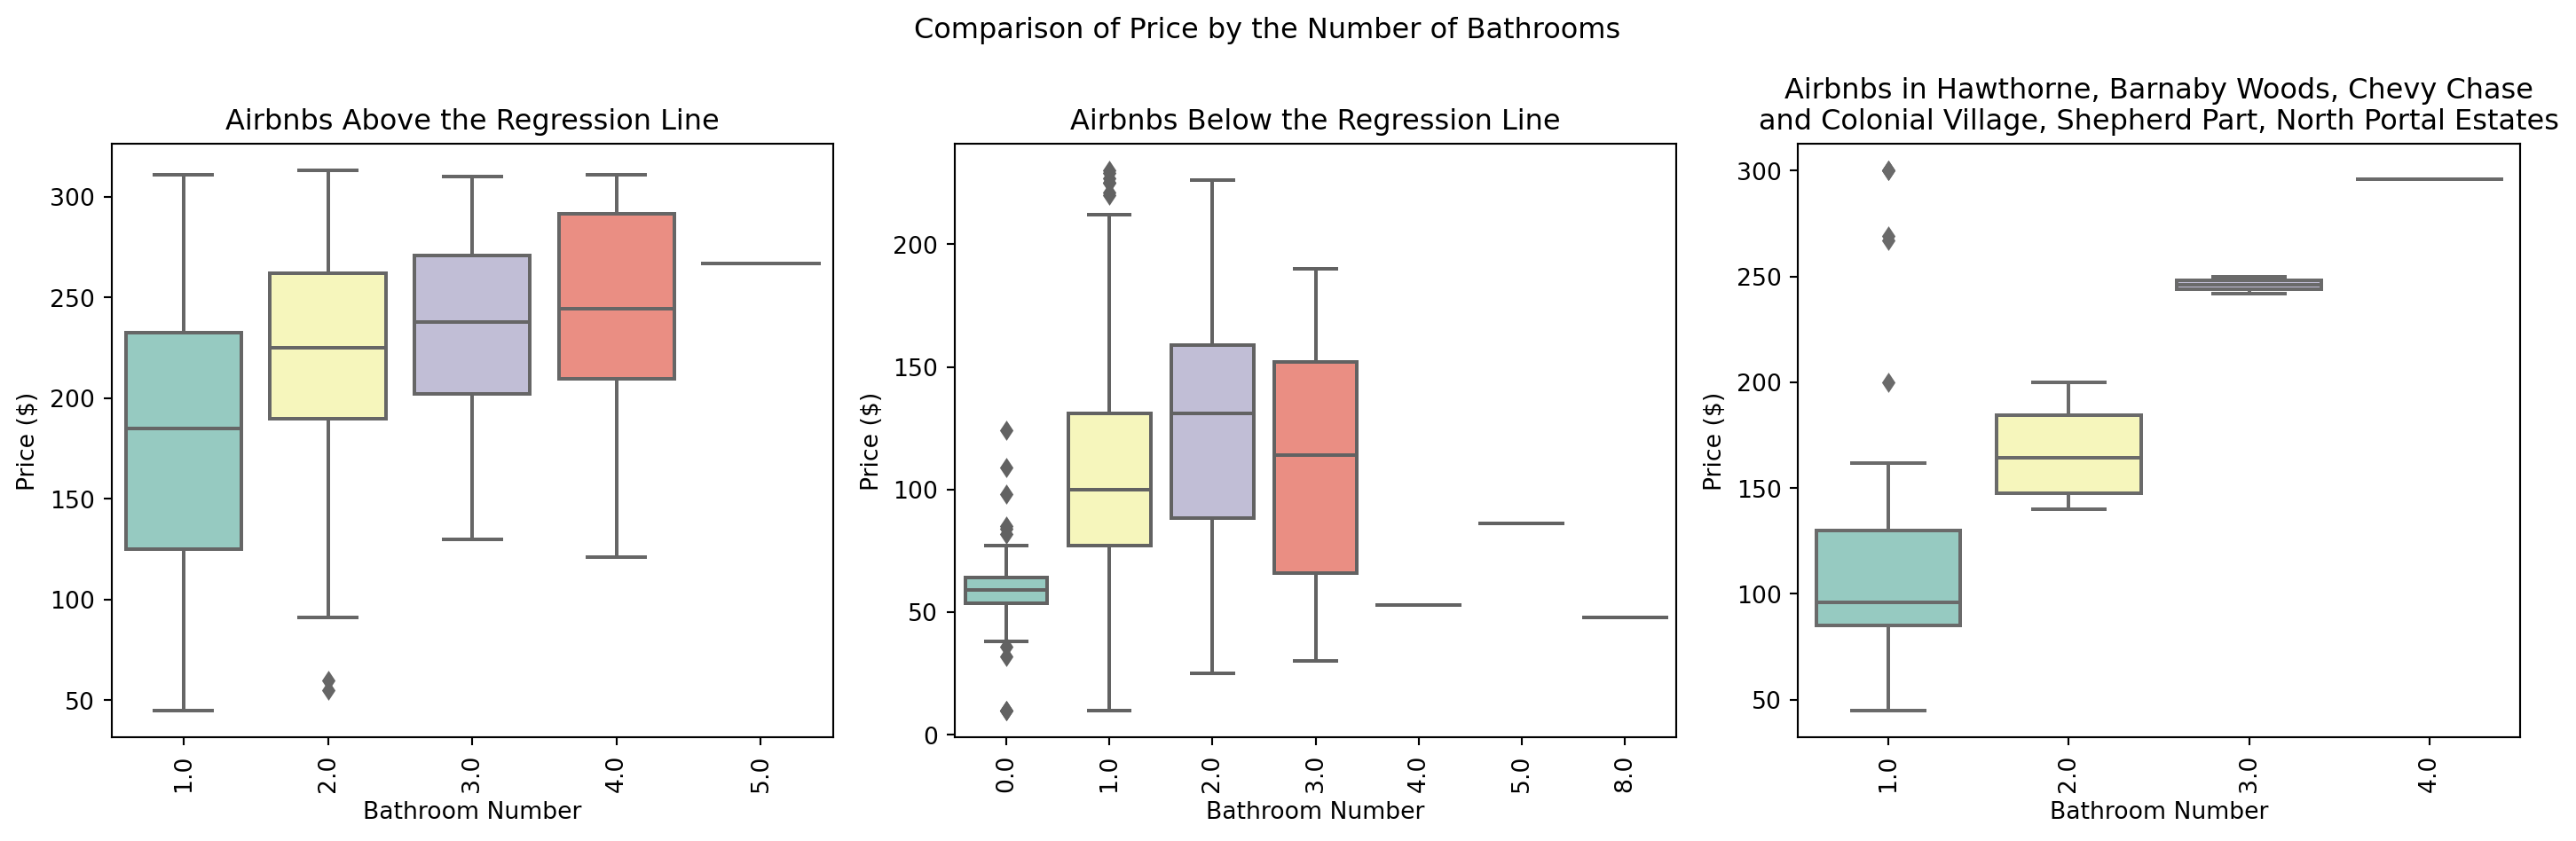

In [28]:
x_a = 'bathroom_num'
y_a = 'price_num'
data_list = [above_avg, below_avg, haw_shp]
name_list = ['Airbnbs Above the Regression Line', 'Airbnbs Below the Regression Line', 'Airbnbs in Hawthorne, Barnaby Woods, Chevy Chase\nand Colonial Village, Shepherd Part, North Portal Estates']

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each subplot and plot the boxplot
for i, (data, name) in enumerate(zip(data_list, name_list)):
    sns.boxplot(data=data, x=x_a, y=y_a, ax=axes[i], palette='Set3')
    axes[i].set_title(name)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('Bathroom Number')
    axes[i].set_ylabel('Price ($)')

plt.suptitle('Comparison of Price by the Number of Bathrooms')
plt.tight_layout()
plt.show()

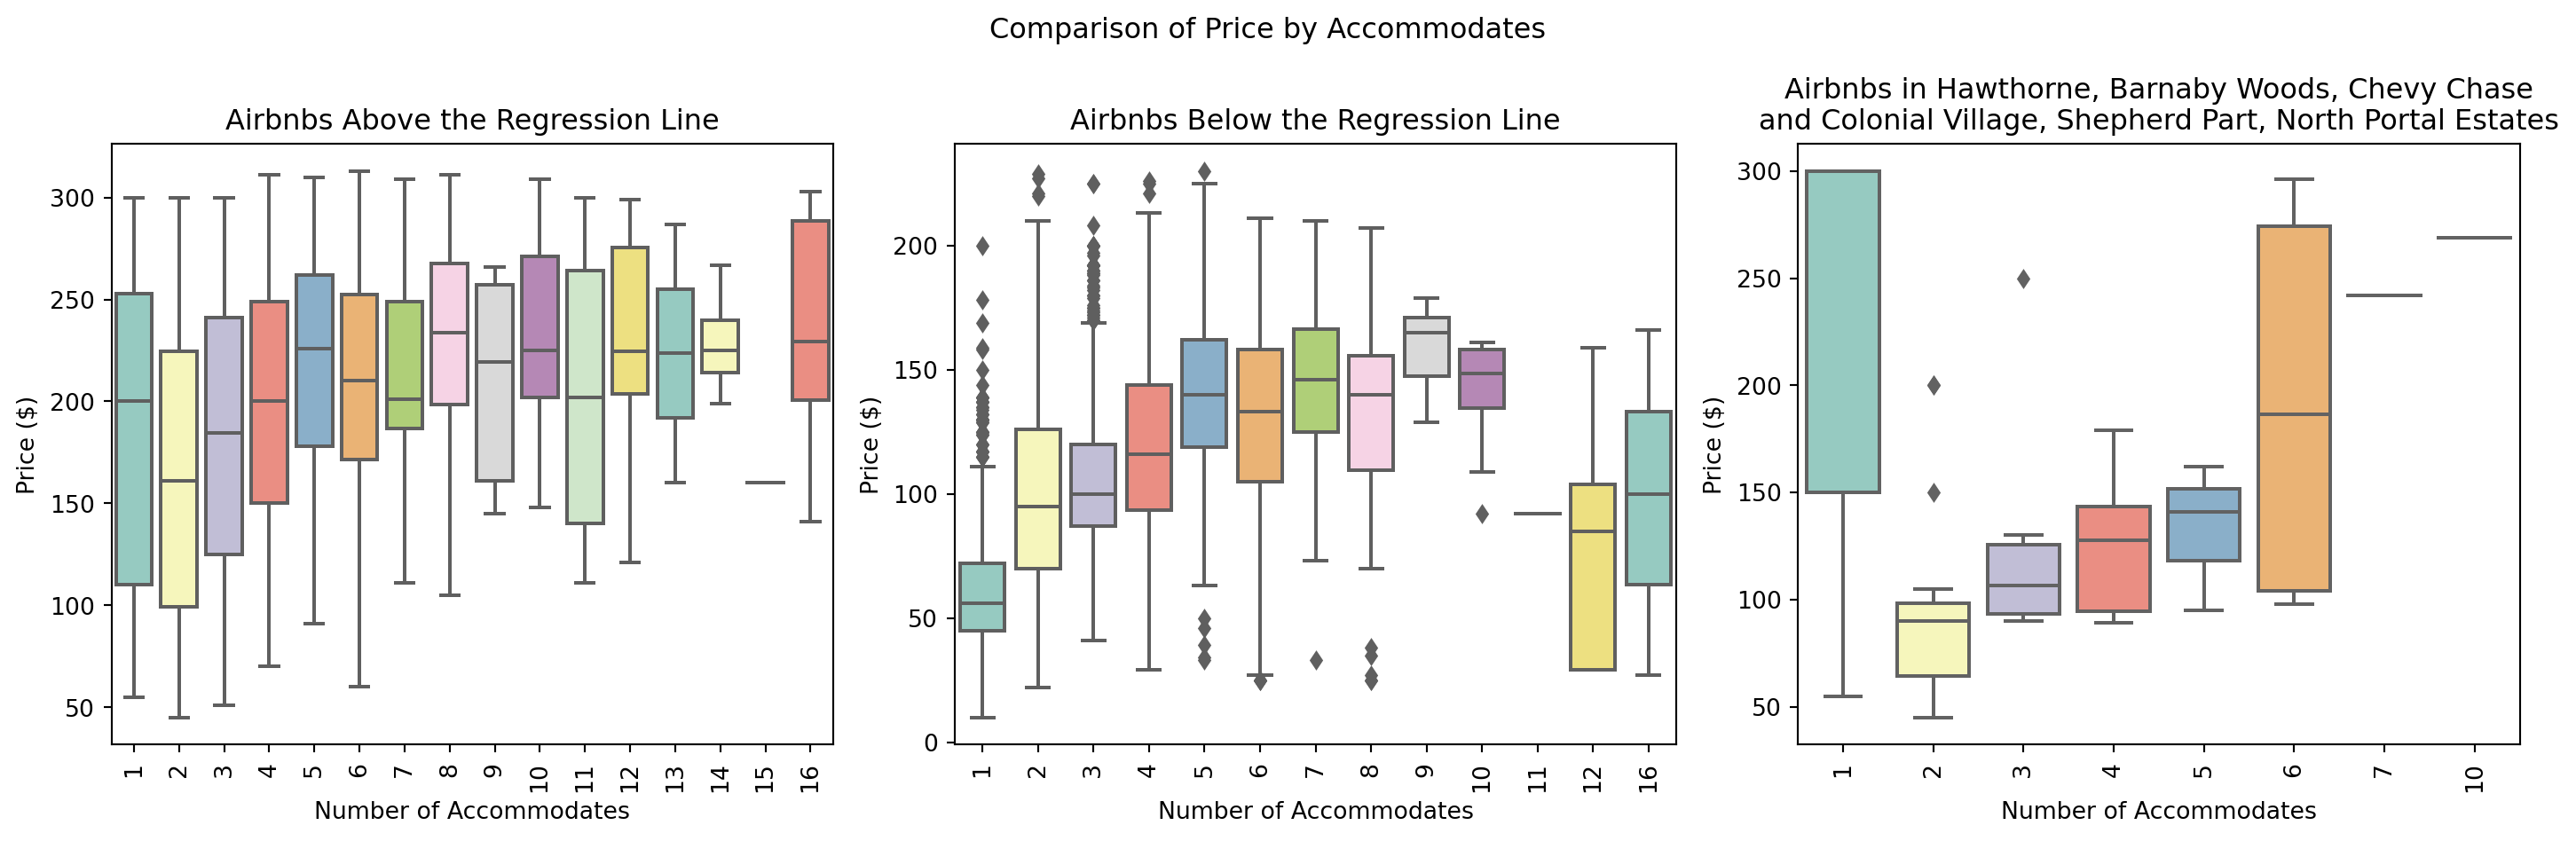

In [29]:
x_a = 'accommodates'
y_a = 'price_num'
data_list = [above_avg, below_avg, haw_shp]
name_list = ['Airbnbs Above the Regression Line', 'Airbnbs Below the Regression Line', 'Airbnbs in Hawthorne, Barnaby Woods, Chevy Chase\nand Colonial Village, Shepherd Part, North Portal Estates']

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each subplot and plot the boxplot
for i, (data, name) in enumerate(zip(data_list, name_list)):
    sns.boxplot(data=data, x=x_a, y=y_a, ax=axes[i], palette='Set3')
    axes[i].set_title(name)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('Number of Accommodates')
    axes[i].set_ylabel('Price ($)')

plt.suptitle('Comparison of Price by Accommodates')
plt.tight_layout()
plt.show()

To see what factors influenced these two neighbourhoods to have relatively expensive Airbnbs, we drew several plots that compared the relationship between price and other variables. The only variables we found that were significant enough were the number of bathrooms and the number of accommodates allowed. 

When we graphed boxplots that showed the relationship between the number of bathrooms and the price of Airbnbs, we saw that for Airbnbs below the regression line, as the number of bathrooms increased Airbnbs became slightly expensive. However, for Airbnbs above the regression line, the price increased as the number of bathrooms increased but after 2 bathrooms, the price decreased, which was an interesting finding. Unlike the trend for these two group however, for Airbnbs in Hawthorne, Barnaby Woods, Chevy Chase and Colonial Village, Shepherd Part, North Portal Estates, the number of bathrooms mattered significantly when determining the price.

When graphing the price according to the number of accommodates allowed, we saw that the price tends to slightly increase as the number of accommodates possible increases for places above the regression line. For Airbnbs below the regression line, it showed results similar to the number of bathrooms; the price for Airbnbs allowing more than 9 accommodates decreased as the number of accommodates increased. However, for Airbnbs in Hawthorne, Barnaby Woods, Chevy Chase and Colonial Village, Shepherd Part, North Portal Estates, prices for Airbnbs that allowed one person were considerably higher than those for the other Airbnbs that allowed more accommodates. This was quite absurd and interesting, so we guessed it would be because there are many private rooms with more than one bathroom or maybe because the rooms are big.

## Bus Stops and Metro Stations in Each Neighbourhood


In [30]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [31]:
bus = pd.read_csv("./dsan_5200_project/Metro_Bus_Stops.csv")
metro = pd.read_csv("./dsan_5200_project/metro_Stations_Regional.csv")

In [32]:
# import pandas as pd
# from math import radians, sin, cos, sqrt, atan2

# # Assuming DataFrame 1 has columns 'x1' and 'y1' for coordinates
# # and DataFrame 2 has columns 'x2' and 'y2' for coordinates

# # Function to calculate distance between two points using Haversine formula
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371.0  # approximate radius of Earth in km

#     lat1_rad = radians(lat1)
#     lon1_rad = radians(lon1)
#     lat2_rad = radians(lat2)
#     lon2_rad = radians(lon2)

#     dlon = lon2_rad - lon1_rad
#     dlat = lat2_rad - lat1_rad

#     a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c  # distance in km
#     return distance

# # Iterate through DataFrame 1 and DataFrame 2
# # and find points within 500m distance
# close_points = []
# for index1, row1 in df.iterrows():
#     x1 = row1['latitude']
#     y1 = row1['longitude']
#     for index2, row2 in bus.iterrows():
#         x2 = row2['Y']
#         y2 = row2['X']
#         distance = haversine(x1, y1, x2, y2)
#         if distance <= 0.5:  # 500m or 0.5km
#             close_points.append((index1, index2, distance))
#         # print(index2)
#     if index1 % 100 == 0:
#         print(index1)
#     # if index1 == 100:
#     #     break

# # Create DataFrame from close_points list
# close_points_df = pd.DataFrame(close_points, columns=['Index1', 'Index2', 'Distance'])

In [33]:
# bus_index = pd.DataFrame(close_points_df.groupby(['Index1']).size()).reset_index()
# bus_index.rename({0:'Bus_Num'},axis=1, inplace=True)
# bus_index.to_csv('./dsan_5200_project/bus_index.csv')

In [34]:
# import pandas as pd
# from math import radians, sin, cos, sqrt, atan2

# # Assuming DataFrame 1 has columns 'x1' and 'y1' for coordinates
# # and DataFrame 2 has columns 'x2' and 'y2' for coordinates

# # Function to calculate distance between two points using Haversine formula
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371.0  # approximate radius of Earth in km

#     lat1_rad = radians(lat1)
#     lon1_rad = radians(lon1)
#     lat2_rad = radians(lat2)
#     lon2_rad = radians(lon2)

#     dlon = lon2_rad - lon1_rad
#     dlat = lat2_rad - lat1_rad

#     a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c  # distance in km
#     return distance

# # Iterate through DataFrame 1 and DataFrame 2
# # and find points within 500m distance
# close_points = []
# for index1, row1 in df.iterrows():
#     x1 = row1['latitude']
#     y1 = row1['longitude']
#     for index2, row2 in metro.iterrows():
#         x2 = row2['Y']
#         y2 = row2['X']
#         distance = haversine(x1, y1, x2, y2)
#         if distance <= 1:  # 500m or 0.5km
#             close_points.append((index1, index2, distance))
#         # print(index2)
#     if index1 % 100 == 0:
#         print(index1)
#     # if index1 == 100:
#     #     break

# # Create DataFrame from close_points list
# close_points_df = pd.DataFrame(close_points, columns=['Index1', 'Index2', 'Distance'])

In [35]:
# metro_index = pd.DataFrame(close_points_df.groupby(['Index1']).size()).reset_index()
# metro_index.rename({0:'Metro_Num'},axis=1, inplace=True)
# metro_index.to_csv('./dsan_5200_project/metro_index.csv')

In [36]:
bus_index = pd.read_csv('./dsan_5200_project/bus_index.csv')
metro_index = pd.read_csv('./dsan_5200_project/metro_index.csv')
joined_df = df.merge(metro_index, left_index=True, right_on='Index1', how='left')
joined_df.reset_index(drop=True,inplace=True)
joined_df = joined_df.merge(bus_index, left_index=True, right_on='Index1', how='left')
joined_df.reset_index(drop=True,inplace=True)

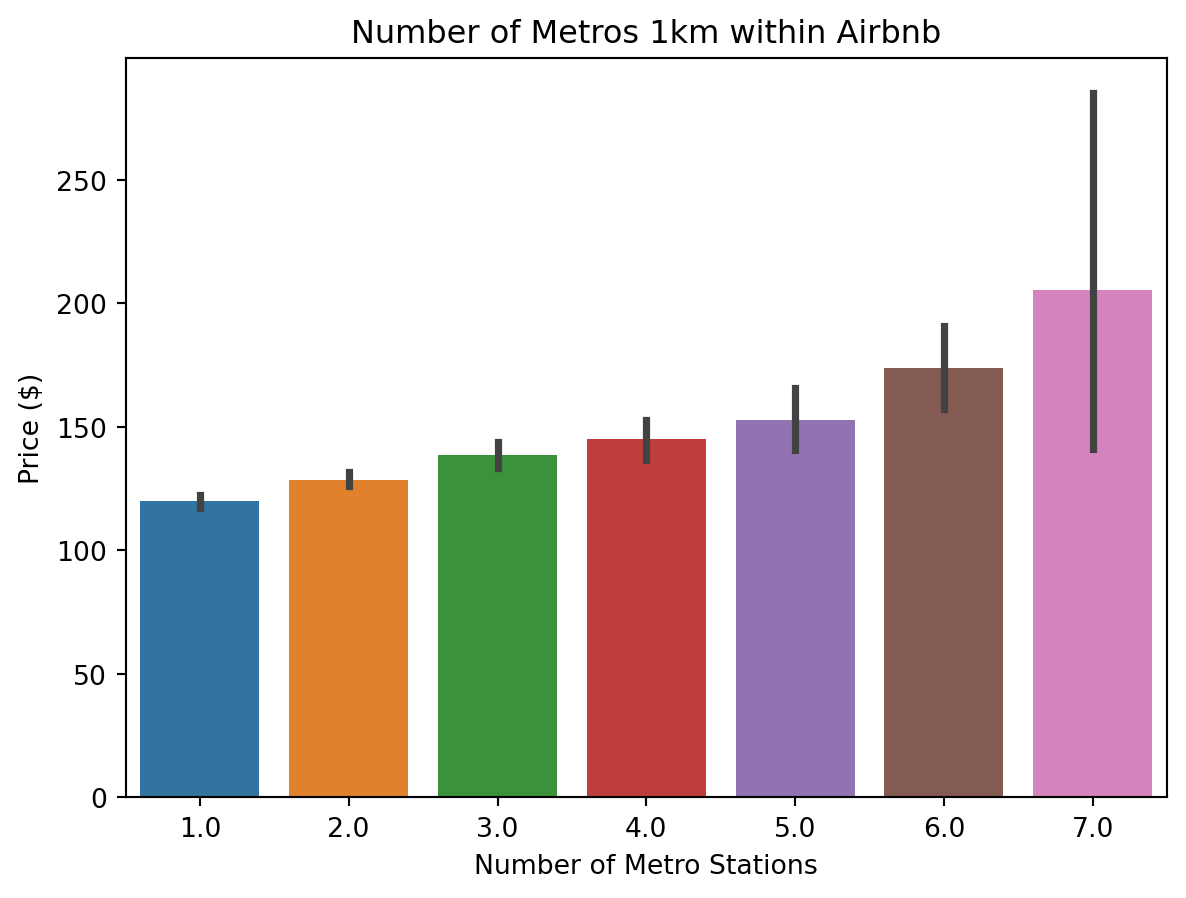

In [37]:
sns.barplot(joined_df,x='Metro_Num', y='price_num')
plt.title('Number of Metros 1km within Airbnb')
plt.xlabel('Number of Metro Stations')
plt.ylabel('Price ($)')
plt.show()

While assessing factors influencing Airbnb pricing in Washington DC, we emphasized the proximity to the National Monument. Additionally, we explored the impact of public transportation access on Airbnb prices, given the city's robust transit system. Tourists often consider transit availability when choosing accommodations, making this a factor worth exploring.

To thoroughly examine this, we sourced two datasets from OpenData DC: one detailing the coordinates of all bus stops in the city, and another documenting the locations of metro train stations. We then calculated the number of bus stops within a 500-meter radius and metro stations within a one-kilometer radius of each Airbnb listing.

Our analysis revealed that the proximity of bus stops does not significantly correlate with Airbnb prices. However, we observed a clear positive correlation with metro station accessibility. Listings closer to multiple metro stations typically form higher price ranges, emphasizing the value that users place on convenient access to public transportation.

## Conclusion: Relationship Between Metro Stations and Distance from the National Monument


In [38]:
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  
    featureidkey='properties.neighbourhood_cleansed',  
    color='median_price',  
    color_continuous_scale="tealrose",  
    mapbox_style="carto-positron",  
    zoom=10,  
    center={"lat": 38.9, "lon": -77.03}, 
    opacity=0.5,  
    labels={'neighbourhood_cleansed':'Area','median_price': 'Median Price',}, 
    hover_data={
        'neighbourhood_cleansed': True,
        'price_num': ':.2f',  
    }
)
fig.update_traces(
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "<span style='font-size:0.9em;'>Median Price:</span> "
        "<span style='font-size:0.9em;'><b>$%{customdata[1]:.2f}</b></span><br>"
    )
)

fig.add_trace(
    go.Scattermapbox(
        lat=metro['Y'],
        lon=metro['X'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color='black',
            opacity=0.7
        ),
        text=metro.apply(lambda row: f"{row['NAME']}", axis=1),
        hoverinfo='text'
    )
    
)

# Adding National Monument marker
fig.add_trace(
    go.Scattermapbox(
        lat=[38.8895],  # Latitude for National Monument
        lon=[-77.0353],  # Longitude for National Monument
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='red',
            opacity=0.8
        ),
        text=["National Monument"],  # Label for the tooltip
        hoverinfo='text'
    )
)

fig.update_layout(
    hoverlabel=dict(
        font=dict(family="Courier New, monospace", size=12),
        bordercolor='pink',
        bgcolor='white'
    ),
    title='Median Airbnb Price and Review by Neighborhood in DC',
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    clickmode='event+select'
)

fig.show()

When plotting metro stations and the National Monument on a map, it's evident that the stations are densely clustered around the monument. Consequently, analyzing the impact of proximity to the monument on Airbnb pricing yields a similar conclusion to that of the proximity to metro stations. While we cannot establish causality from this correlation, the data strongly suggests that both proximity to the National Monument and access to nearby metro stations are significant factors influencing Airbnb prices in Washington DC.

## Wordcloud for Host Description

In our exploration, we took a look into the language used in host descriptions, aiming to understand what hosts believe appeals most to guests. Interestingly, we found that the most prevalent terms were associated with amenities and aesthetics, such as "fully equipped," "equipped kitchen," "thoughtfully designed," and "beautiful." Our prior analysis identified the key factors of pricing to be the number of bathrooms, accommodation capacity, proximity to the monument, and accessibility to public transportation. This discrepancy suggests that while hosts focus on promoting the aesthetic and functional aspects of their properties, these may not align perfectly with the features most valued by users. This insight indicates an opportunity for hosts to differentiate themselves by emphasizing the attributes that truly resonate with guests and influence pricing, thereby potentially enhancing their competitiveness in the market.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sungyeonkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


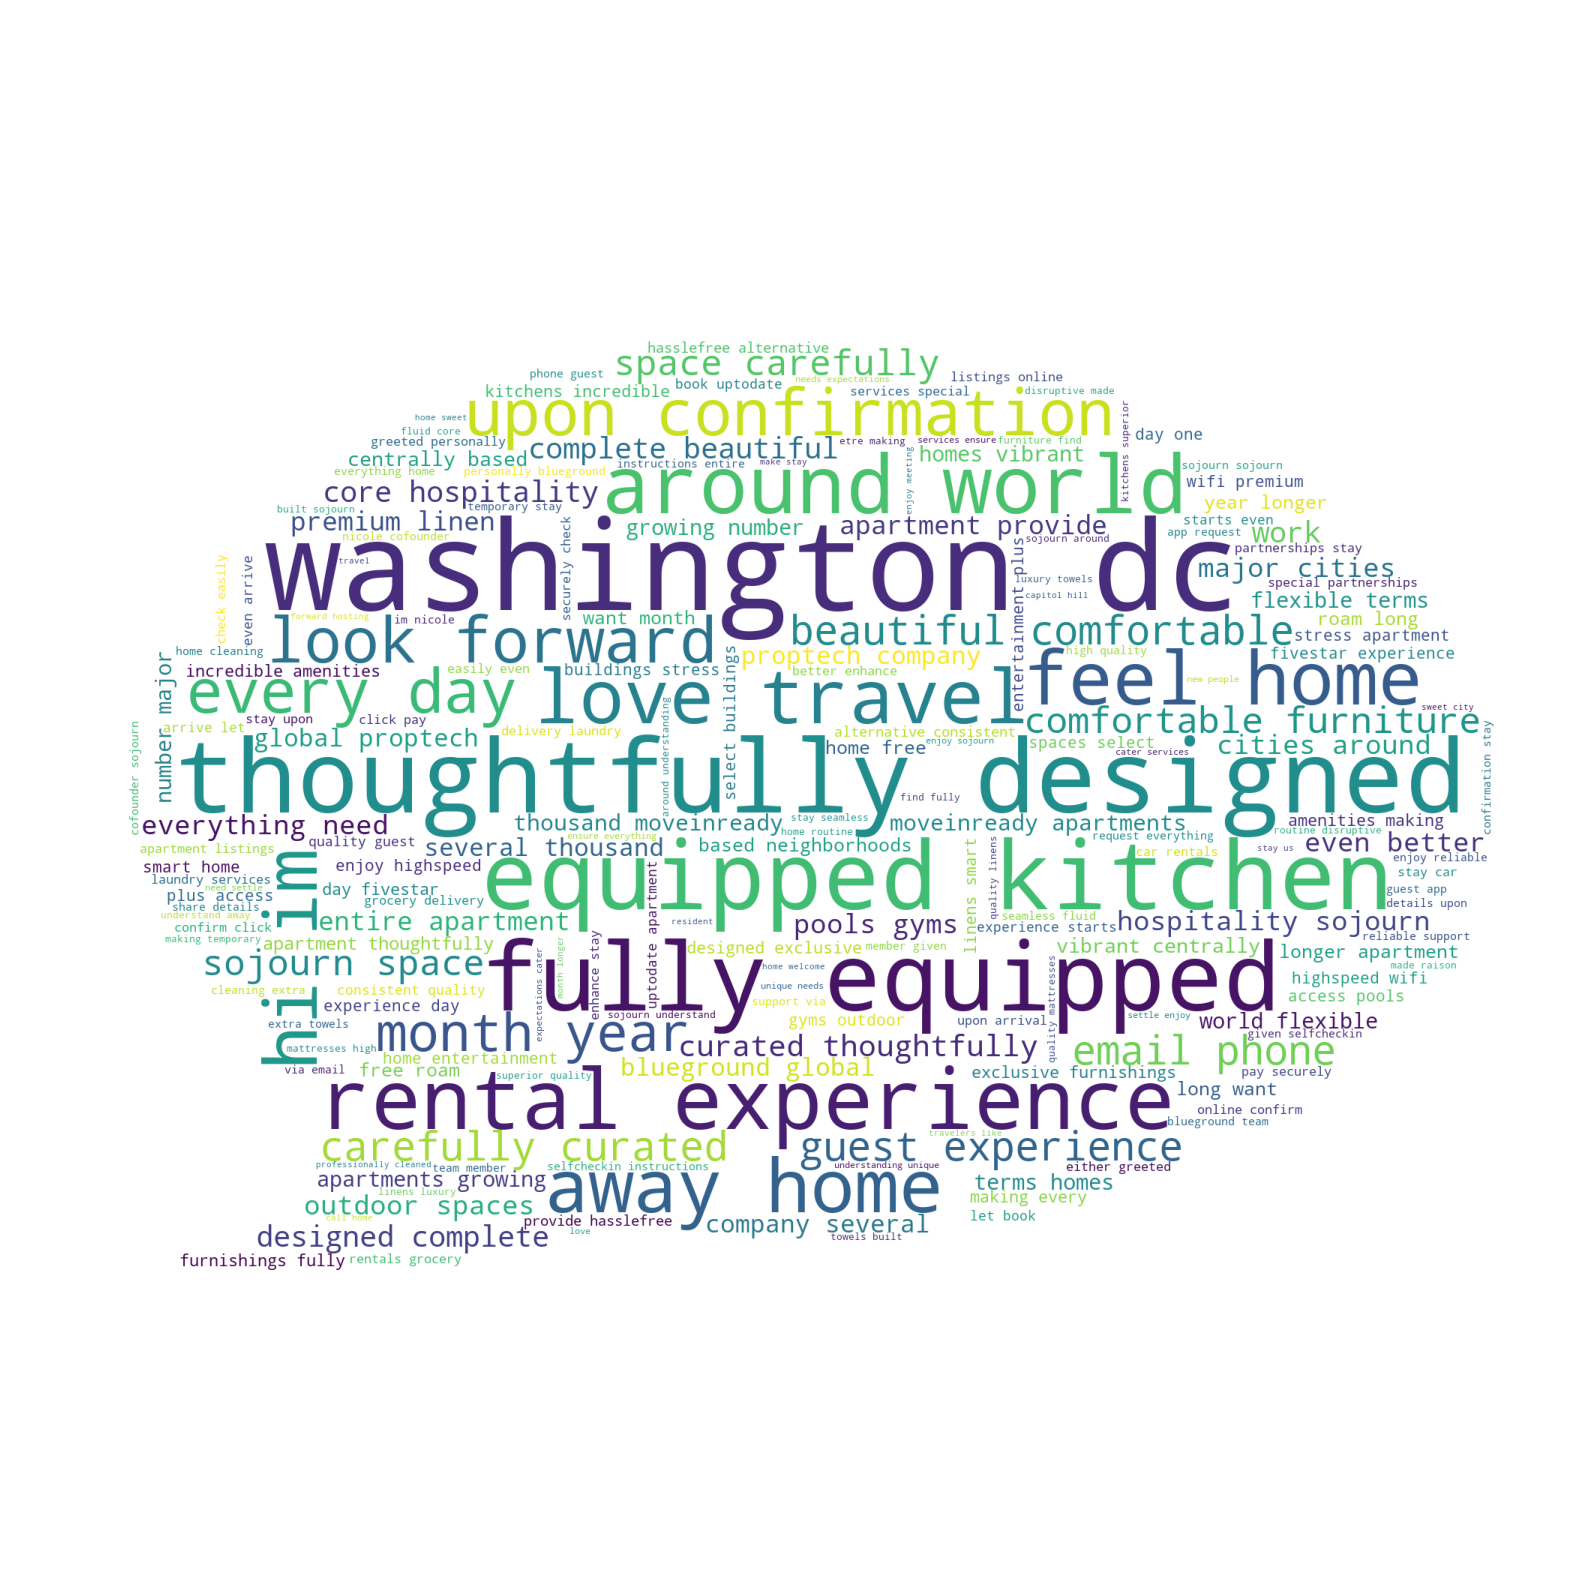

In [39]:
import pandas as pd
import numpy as np
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.corpus import stopwords
import nltk


host_about_text = df['host_about'].dropna()
combined_text = " ".join(host_about_text)

# Removing punctuation
translator = str.maketrans('', '', string.punctuation)
text_no_punctuation = combined_text.translate(translator)
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove basic stopwords
text_no_basic_stopwords = ' '.join([word for word in text_no_punctuation.lower().split() if word not in stop_words])
mask = np.array(Image.open("./dsan_5200_project/comment.png"))
# Generate the word cloud with the simplified stopword set
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10,mask=mask).generate(text_no_basic_stopwords)

# Display the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Curation Plot
### Airbnbs that have a good review score, more than 2 bathrooms, lower price than the average price by each neighbourhood

After seeing that the number of bathrooms and the location are the most important factors when deciding what aribnbs people want to stay in, we wanted to show which airbnbs would be a preferable place to stay. As people would want to stay in different neighbourhoods, we decided to show airbnbs that have more bathrooms than the average number of bathrooms in the neighbourhood, and where the location score is higher than the average location score in that area. We also thought price would be a factor that people would be interested in, so we also filtered out the places that have higher prices than the average price of airbnbs in the neighbourhood.


In [40]:
temp = df.reset_index()
# temp.head()

In [41]:
index = []
unique_neigh = temp['neighbourhood_cleansed'].unique()
for i in unique_neigh:
    tem = temp[temp['neighbourhood_cleansed'] == i]
    avg_rev = tem.groupby(['neighbourhood_cleansed'])['review_scores_location'].mean().values[0]
    avg_price = tem.groupby(['neighbourhood_cleansed'])['price_num'].mean().values[0]
    avg_bath = tem.groupby(['neighbourhood_cleansed'])['bathroom_num'].mean().values[0]

    tem = tem[(tem['review_scores_location'] > avg_rev) & (tem['price_num'] < avg_price) &(tem['bathroom_num'] > avg_bath)]

    index.extend(tem['index'])

In [42]:
curation = temp[temp['index'].isin(index)]

In [43]:
neighbourhood_data = df.groupby('neighbourhood_cleansed').agg({
    'price_num': 'median',
    'review_scores_location':'mean'
}).reset_index()

In [44]:
# Read the data
dc_wards = gpd.read_file("./dsan_5200_project/neighbourhoods.geojson")
dc_wards['color'] = 1

In [45]:
dc_wards['neighbourhood_cleansed'] = dc_wards['neighbourhood']

In [46]:
neighbourhood_price = temp.groupby(['neighbourhood_cleansed'])['price_num'].mean().reset_index()

In [47]:
test = pd.merge(dc_wards,neighbourhood_price,on='neighbourhood_cleansed')

In [48]:
import pandas as pd
import folium
import json
from folium import Icon
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='cartodbpositron')  # Changed tiles here

choropleth = folium.Choropleth(
    geo_data=test,
    data=test,
    columns=['neighbourhood_cleansed','price_num'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density in DC'
).add_to(m)

# neighbourhood_data = df_withtop_10.groupby('neighbourhood_cleansed').agg({
#     'price_num': 'mean',
#     'average_review_score':'mean',
#     'latitude': 'mean',
#     'longitude': 'mean'
# }).reset_index()


for index, row in curation.iterrows():
    popup_html = f"""
    <div style="width:200px;">
        <strong>{row['neighbourhood_cleansed']}</strong><br>
        Average price: ${round(row['price_num'], 2)}<br>
        Average rating: {round(row['review_scores_location'], 2)}
    </div>
    """
    tooltip_html = f"""
    <div style="width:200px;">
        <strong>{row['neighbourhood_cleansed']}</strong><br>
        Bathrooms: {row['bathroom_num']}<br>
        Price: ${round(row['price_num'], 2)}<br>
        Review Score: {row['review_scores_location']}
    </div>
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(popup_html, max_width=265),
        tooltip=tooltip_html,  # Modified tooltip content
        icon=Icon(color='blue', icon='info-sign')
    ).add_to(m)


# Display the map
m

## Miscellaneous: Top 10 Airbnbs Used

Additionally, we wanted to look at the 10 Airbnbs that are most used. We assumed that if there are more airbnbs in a certain area than another, it would also mean that there would be a higher demand for airbnbs in that area.


In [49]:
top_10_list = df['neighbourhood_cleansed'].value_counts().head(10).keys()
df_top_10 = df[df['neighbourhood_cleansed'].isin(top_10_list)]

In [50]:
dc_wards = gpd.read_file("./dsan_5200_project/ACS_Demographic_Characteristics_DC_Ward.geojson")[
    ["NAMELSAD", "DP05_0001E", "geometry"]
]

### Top 10 Airbnbs and the Population

We wanted to see if there was any relationship between the top 10 airbnbs and other variables, such as price, location, review scores, etc.
The plots below help understand why these airbnbs have a higher demand.

If looking at the population map and the location score distribution map, it seems that the more people there are and the higher review score for location it is, people tend to stay in that area. So we first assumed that safety issues were an important factor when deciding where to stay.


In [51]:
import plotly.graph_objects as go

neighbourhood_data = df_top_10.groupby('neighbourhood_cleansed').agg({
    'median_price': 'median',
    'median_location_review': 'median',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

df_reviews = df.groupby(["neighbourhood_cleansed"])[['review_scores_rating', 'review_scores_communication', 
                                                     'review_scores_checkin', 'review_scores_cleanliness', 
                                                     'review_scores_location', 'review_scores_value']].median().reset_index()

fig = px.choropleth_mapbox(
    df_reviews,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  # Column in merged_gdf for neighborhood names
    featureidkey='properties.neighbourhood_cleansed',  # Key in GeoJSON for neighborhood names
    color='review_scores_location',  # Column in merged_gdf for color scale
    color_continuous_scale="tealrose",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 38.9, "lon": -77.03},
    opacity=0.5,
    labels={'value': 'price'}
)

fig.add_trace(
    go.Scattermapbox(
        lat=neighbourhood_data['latitude'],
        lon=neighbourhood_data['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color='black',
            opacity=0.7
        ),
        text=neighbourhood_data.apply(lambda row: f"{row['neighbourhood_cleansed']}<br>Median Price: ${round(row['median_price'], 2)}", axis=1),
        hoverinfo='text'
    )
    
)

# Add buttons to update layout
fig.update_layout(updatemenus=[{"active": 0}],
                  title="Choropleth Map for Location Review Scores",  # Initial title
                  margin={"r": 0, "t": 0, "l": 0, "b": 0},
                  coloraxis_colorbar_title="Review Scores")

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

We then also looked at the price if it was a factor that determined people's choice of selection. It did seem that while people did avoid places that were too expensive, they did try to stay in the middle of DC, and this confirmed that location would be an important factor. Other than safety issues, however, we also thought the places were more popular because they are places suitable for attractions and have good public transportations.


In [52]:
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_dict,
    locations='neighbourhood_cleansed',  
    featureidkey='properties.neighbourhood_cleansed',  
    color='median_price',  
    color_continuous_scale="tealrose",  
    mapbox_style="carto-positron",  
    zoom=10,  
    center={"lat": 38.9, "lon": -77.03}, 
    opacity=0.5,  
    labels={'neighbourhood_cleansed':'Area','median_price': 'Median Price',}, 
    hover_data={
        'neighbourhood_cleansed': True,
        'price_num': ':.2f',  
    }
)
fig.update_traces(
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "<span style='font-size:0.9em;'>Median Price:</span> "
        "<span style='font-size:0.9em;'><b>$%{customdata[1]:.2f}</b></span><br>"
    )
)

fig.add_trace(
    go.Scattermapbox(
        lat=neighbourhood_data['latitude'],
        lon=neighbourhood_data['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color='black',
            opacity=0.7
        ),
        text=neighbourhood_data.apply(lambda row: f"{row['neighbourhood_cleansed']}<br>Median Price: ${round(row['median_price'], 2)}", axis=1),
        hoverinfo='text'
    )
    
)

fig.update_layout(
    hoverlabel=dict(
        font=dict(family="Courier New, monospace", size=12),
        bordercolor='pink',
        bgcolor='white'
    ),
    title='Median Airbnb Price and Review by Neighborhood in DC',
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    clickmode='event+select'
)

fig.show()